In [1]:
# import packages
import os
import pickle
import numpy as np 
import matplotlib.pyplot as plt
from keras.datasets import mnist 

## Load the Dataset

In [17]:
(train_x_orig, train_y_orig), (test_x_orig, test_y_orig) = mnist.load_data()

In [18]:
print(train_x_orig.shape)
print(train_y_orig.shape)

(60000, 28, 28)
(60000,)


y = 1


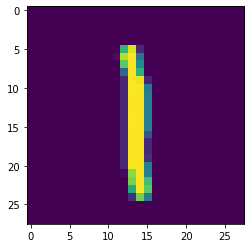

In [19]:
# show some data
index = 14
plt.imshow(train_x_orig[index])
print("y = " + str(train_y_orig[index]))

In [20]:
# reshape training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# standardize data to values between 0 and 1. 
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255. 

# standardize data to fit with softmax output
train_y = np.zeros((10, train_y_orig.shape[0]))
test_y = np.zeros((10, test_y_orig.shape[0]))
for count, y in enumerate(train_y_orig):
    train_y[y][count] = 1
for count, y in enumerate(test_y_orig):
    test_y[y][count] = 1

In [21]:
print(train_x.shape)
print(train_y.shape)

(784, 60000)
(10, 60000)


## Initialize the parameters

In [3]:
# Initialize parameters for this nerual network
def initialize_parameters(layer_dimension):
    parameters = {}

    L = len(layer_dimension)

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dimension[l], layer_dimension[l-1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layer_dimension[l], 1))

    return parameters

In [5]:
parameters = initialize_parameters([20, 10, 2])
print(parameters["W1"].shape)
print(parameters["b1"].shape)
print(parameters["W2"].shape)
print(parameters["b2"].shape)

(10, 20)
(10, 1)
(2, 10)
(2, 1)


## Activation functions

In [2]:
# Sigmoid activation function
def sigmoid(Z):

    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

# The backward propagation for Sigmoid function
def sigmoid_backward(dA, cache):
    Z = cache 
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [ ]:
# Relu activation function
def relu(Z):

    A = np.maximum(0,Z)  
    cache = Z 
    return A, cache

# The backward propagation for Relu function
def relu_backward(dA, cache):

    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    return dZ

In [ ]:
# Softmax activation function
def softmax(Z):

    e = np.exp(Z - np.max(Z))
    A = e / e.sum()
    cache = Z

    return A, cache

# The backward propagation for Softmax function
def softmax_backward(dA, cache): 

    Z = cache 

    e = np.exp(Z - np.max(Z))
    A = e / e.sum()

    dZ = A * (dA - np.sum(dA * A))

    return dZ 

## Forward Propagation

### Activation functions

In [3]:
def linear_forward(A, W, b):

    Z = np.dot(W,A)+b
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    
    # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".       
    Z, linear_cache = linear_forward(A_prev,W,b)

    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)      
    
    elif activation == "relu":
        A, activation_cache = relu(Z)
    
    elif activation == "softmax":
        A, activation_cache = softmax(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

def n_model_forward(X, parameters):
    caches = []
    A = X

    # number of layers in the neural network
    L = len(parameters) // 2
    
    # Using a for loop to replicate [LINEAR->RELU] (L-1) times
    for l in range(1, L):
        A_prev = A 

        # Implementation of LINEAR -> RELU.
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")

        # Adding "cache" to the "caches" list.
        caches.append(cache)

    
    # Implementation of LINEAR -> SIGMOID.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    
    # Adding "cache" to the "caches" list.
    caches.append(cache)
            
    return AL, caches

In [4]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ, A_prev.T)
    db = 1./m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, cache[1])
   
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, cache[1])
    
    elif activation == "softmax":
        dZ = sigmoid_backward(dA, cache[1])
    
    dA_prev, dW, db = linear_backward(dZ, cache[0])

    return dA_prev, dW, db

def n_model_backward(AL, Y, caches):
    grads = {}

    # the number of layers
    L = len(caches)
    m = AL.shape[1]

    # after this line, Y is the same shape as AL
    Y = Y.reshape(AL.shape)
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")

    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". 
        # Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 

        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [5]:
def compute_cost(AL, Y):
    # number of examples
    m = Y.shape[1]

    # Compute loss from AL and y.
    cost = -np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))/m
    # cost = -np.mean(Y * np.log(AL + 1e-8))

    cost = np.squeeze(cost)
    
    return cost

def update_parameters(parameters, grads, learning_rate):
    # number of layers in the neural network
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
    return parameters

def train(X, Y, parameters, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    # keep track of cost
    costs = []

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = n_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = n_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Every 100 iterations: 
        if print_cost and i % 10 == 0:

            # print cost value 
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)

            # save parameters
            # pickle.dump(parameters, open('parameters.pkl', 'wb'))            

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

def predict(X, parameters):
    m = X.shape[1]

    # number of layers in the neural network
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = n_model_forward(X, parameters)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0   
        
    return p


In [10]:
def main(): 

    # load training data 
    train_x, train_y, test_x, test_y = load_dataset()

    # initialize model 
    f = "parameters.pkl" 
    if os.path.exists(f): 
        parameters = pickle.load(open(f, 'rb'))
    else: 
        parameters = initialize_parameters(layer_dimension=[784, 20, 10])

    # train the model
    train(train_x, train_y, parameters, learning_rate = 0.2, num_iterations = 50, print_cost = True)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(predict(train_x, parameters) - train_y)) * 100))

Cost after iteration 0: 6.934564
Cost after iteration 10: 3.341286
Cost after iteration 20: 3.295258
Cost after iteration 30: 3.118216
Cost after iteration 40: 2.682972


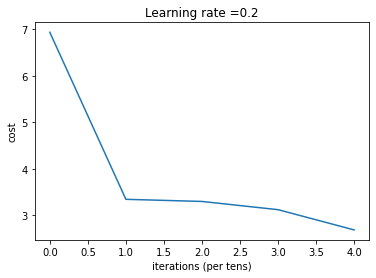

train accuracy: 83.67333333333333 %


In [11]:
main()